## PUDL

In [11]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly

In [3]:
import chart_studio
import os


username = os.environ["CHART_STUDIO_USERNAME"]
api_key = os.environ["CHART_STUDIO_KEY"]
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [4]:
import pandas as pd
import sqlalchemy as sa

# Download pudl.sqlite ~10 GB
# https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/dev/pudl.sqlite

engine = sa.create_engine("sqlite:////Users/bendnorman/catalyst/dagster-pudl-work/pudl_output/full_eia_pudl.sqlite")

with engine.connect() as con:
    plants_entity_eia = pd.read_sql_table("plants_entity_eia", con)
    generation = pd.read_sql_table("denorm_generation_fuel_combined_yearly_eia923", con)


In [5]:
plants_entity_eia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16212 entries, 0 to 16211
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   plant_id_eia    16212 non-null  int64  
 1   plant_name_eia  15943 non-null  object 
 2   city            15130 non-null  object 
 3   county          15306 non-null  object 
 4   latitude        15221 non-null  float64
 5   longitude       15412 non-null  float64
 6   state           15938 non-null  object 
 7   street_address  14713 non-null  object 
 8   zip_code        15420 non-null  object 
 9   timezone        15943 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.2+ MB


In [6]:
generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244796 entries, 0 to 244795
Data columns (total 16 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   report_date                          244796 non-null  datetime64[ns]
 1   plant_id_eia                         244796 non-null  int64         
 2   plant_id_pudl                        244796 non-null  int64         
 3   plant_name_eia                       244796 non-null  object        
 4   utility_id_eia                       244796 non-null  int64         
 5   utility_id_pudl                      244796 non-null  int64         
 6   utility_name_eia                     244796 non-null  object        
 7   energy_source_code                   244796 non-null  object        
 8   fuel_type_code_pudl                  244796 non-null  object        
 9   prime_mover_code                     244796 non-null  object        
 

In [7]:
generation = generation.merge(plants_entity_eia, on=["plant_id_eia"], validate="m:1", how="left")

In [8]:
generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244796 entries, 0 to 244795
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   report_date                          244796 non-null  datetime64[ns]
 1   plant_id_eia                         244796 non-null  int64         
 2   plant_id_pudl                        244796 non-null  int64         
 3   plant_name_eia_x                     244796 non-null  object        
 4   utility_id_eia                       244796 non-null  int64         
 5   utility_id_pudl                      244796 non-null  int64         
 6   utility_name_eia                     244796 non-null  object        
 7   energy_source_code                   244796 non-null  object        
 8   fuel_type_code_pudl                  244796 non-null  object        
 9   prime_mover_code                     244796 non-null  object        
 

In [49]:
def plot_state_generation(generation: pd.DataFrame, state:str, publish=False, local=True):
    state_generation = generation.query("state == @state")

    fuel_type_grp = state_generation.groupby(["report_date", "fuel_type_code_pudl"])["net_generation_mwh"].sum().reset_index()

    traces = []

    for fuel_type in generation.fuel_type_code_pudl.unique():
        fuel_type_net_gen = fuel_type_grp.query("fuel_type_code_pudl == @fuel_type")
        generation_gwh = (fuel_type_net_gen.net_generation_mwh / 1_000).round(decimals=0).astype("Int64")
        traces.append(go.Scatter(
            x=fuel_type_net_gen.report_date,
            y=generation_gwh,
            stackgroup="one",
            name=fuel_type,
            marker_colorscale=plotly.colors.sequential.Viridis,
        ))

    fig = go.Figure(data=traces)
    # fig.update_layout(showlegend=False)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.update_layout({
    # "plot_bgcolor": "rgba(0, 0, 0, 0)",
    "paper_bgcolor": "rgba(0, 0, 0, 0)",
    })
    fig.update_layout(
        xaxis_title="Years",
        yaxis_title="Gigawatt Hours (Gwh)",
        hovermode='x',
        yaxis_tickformat=",.2r"
    )
    if local:
        fig.show()
    if publish:
        py.plot(fig, filename = f"{state.lower()}_electricity_generation", auto_open=False)


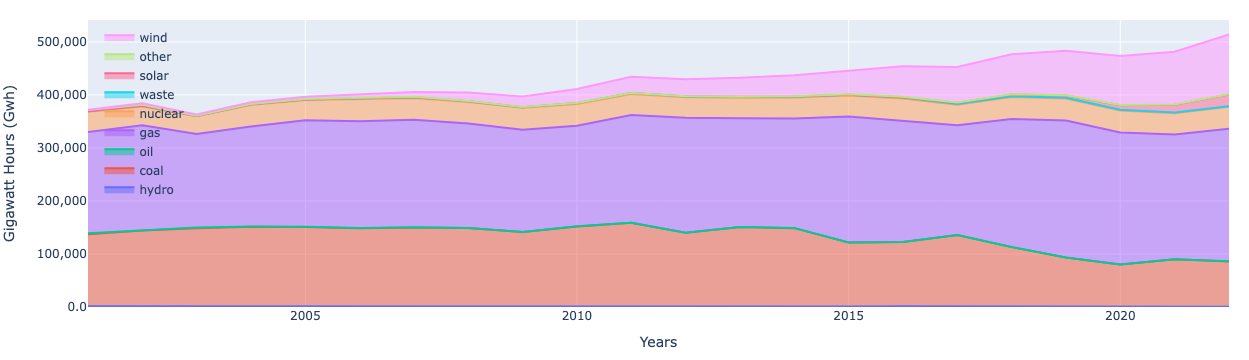

In [52]:
plot_state_generation(generation, "TX", publish=False, local=True)

## Publish all the state graphs

In [53]:
from tqdm import tqdm

for state in tqdm(generation.state.dropna().unique()):
    plot_state_generation(generation, state, publish=True, local=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:32<00:00,  5.35s/it]


## Generate rnadom collection of states

In [118]:
states = sorted(generation.state.dropna().str.lower().unique())

In [123]:
start_date = '2022-06-14'
end_date = '2024-10-07'

# Create a Series of dates between the start and end dates
date_series = pd.date_range(start=start_date, end=end_date)

In [126]:
len(date_series)

847

In [132]:
import random

n = len(date_series)
random_states = [random.choice(states) for _ in range(n)]

pd.DataFrame({"dates": date_series.to_list(), "states": random_states}).to_csv("state_and_dates.csv", index=False)